# Hyperparameter Tuning

Objective: Optimize LightGBM parameters for both classifier and regressor
          components of the two-stage model.

Strategy:
- Bayesian optimization via Optuna
- Tune classifier and regressor separately
- Focus on Horizon 1 (transfer insights to H2/H3)
- Target: 3-7% MAE improvement

## Setup


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, roc_auc_score
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
import warnings

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('darkgrid')

# Load preprocessed data from Notebook 04
BASE_DIR = Path.cwd().parent
PROCESSED_DIR = BASE_DIR / "data" / "processed"
FEATURES_FILE = PROCESSED_DIR / "fpl_features_engineered.csv"

df = pd.read_csv(FEATURES_FILE)
print(f"Loaded: {df.shape}")

Loaded: (93666, 151)


## 1. Prepare Data (from Notebook 03)

In [3]:
for stat in ['influence', 'creativity', 'threat']:
    for window in [3, 5]:
        df[f'{stat}_roll_mean_{window}'] = (
            df.groupby('element')[stat]
            .transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean())
        )

df['yellow_cards_roll_sum_5'] = df.groupby('element')['yellow_cards'].transform(lambda x: x.shift(1).rolling(5).sum()).fillna(0)
df['red_cards_roll_sum_10'] = df.groupby('element')['red_cards'].transform(lambda x: x.shift(1).rolling(10).sum()).fillna(0)
df['penalties_missed_roll_sum_10'] = df.groupby('element')['penalties_missed'].transform(lambda x: x.shift(1).rolling(10).sum()).fillna(0)
df['penalties_saved_roll_sum_10'] = df.groupby('element')['penalties_saved'].transform(lambda x: x.shift(1).rolling(10).sum()).fillna(0)

df['form_divergence'] = df['total_points_roll_mean_3'] - df['total_points_roll_mean_10']

df['roi_roll_5'] = (df['total_points_roll_mean_5'] / df['value']) * 10
df['roi_roll_3'] = (df['total_points_roll_mean_3'] / df['value']) * 10

# Before feature selection
df['position_encoded'] = df['position'].map({'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3})

opponent_strength = df.groupby(['season', 'opponent_team'])['goals_conceded'].mean()
df['opponent_defensive_strength'] = df.apply(lambda x: opponent_strength.get((x['season'], x['opponent_team']), 1.5), axis=1)

scout_features = [
    # Nailedness (30% of prediction power)
    'minutes_roll_mean_3', 'minutes_roll_mean_5', 'minutes_roll_mean_10',
    'minutes_roll_std_5', 'is_starter',
    
    # Form (Recent 3-5 GW)
    'total_points_roll_mean_3', 'total_points_roll_mean_5',
    'goals_scored_roll_mean_3', 'assists_roll_mean_3',
    
    # Class (Long-term 10 GW)
    'total_points_roll_mean_10', 'goals_scored_roll_mean_10',
    
    # Explosiveness
    'total_points_roll_max_5', 'total_points_roll_std_5',
    
    # xG Truth
    'expected_goals_roll_mean_3', 'expected_assists_roll_mean_3',
    'expected_goal_involvements_roll_mean_5', 'goals_vs_xg',
    
    # Defense
    'clean_sheets_roll_mean_3', 'clean_sheets_roll_mean_5',
    
    # Discipline
    'yellow_cards_roll_sum_5', 'penalties_missed_roll_sum_10',
    
    # ICT Index
    'ict_index_roll_mean_5', 'bps_roll_mean_5','influence_roll_mean_5', 'creativity_roll_mean_5', 'threat_roll_mean_5',
    
    # Momentum
    'points_momentum_1gw', 'points_acceleration', 'form_divergence',
    
    # Context
    'was_home', 'position_percentile', 'opponent_defensive_strength', 'position_encoded',
    
    # Efficiency 
    'roi_roll_3', 'roi_roll_5'
]

feature_cols = [c for c in scout_features if c in df.columns]


print(f"  Final Feature Count: {len(feature_cols)}")
for c in scout_features:
    if c in df.columns:
      print(f"    - {c}")

  Final Feature Count: 35
    - minutes_roll_mean_3
    - minutes_roll_mean_5
    - minutes_roll_mean_10
    - minutes_roll_std_5
    - is_starter
    - total_points_roll_mean_3
    - total_points_roll_mean_5
    - goals_scored_roll_mean_3
    - assists_roll_mean_3
    - total_points_roll_mean_10
    - goals_scored_roll_mean_10
    - total_points_roll_max_5
    - total_points_roll_std_5
    - expected_goals_roll_mean_3
    - expected_assists_roll_mean_3
    - expected_goal_involvements_roll_mean_5
    - goals_vs_xg
    - clean_sheets_roll_mean_3
    - clean_sheets_roll_mean_5
    - yellow_cards_roll_sum_5
    - penalties_missed_roll_sum_10
    - ict_index_roll_mean_5
    - bps_roll_mean_5
    - influence_roll_mean_5
    - creativity_roll_mean_5
    - threat_roll_mean_5
    - points_momentum_1gw
    - points_acceleration
    - form_divergence
    - was_home
    - position_percentile
    - opponent_defensive_strength
    - position_encoded
    - roi_roll_3
    - roi_roll_5


In [ ]:
# Temporal split
def create_temporal_split(df):
    train_mask = df['season'].isin(['2021-22', '2022-23', '2023-24'])
    val_mask = (df['season'] == '2024-25') & (df['GW'] >= 15)
    test_mask = (df['season'] == '2025-26') & (df['GW'] <= 12)
    
    return df[train_mask].copy(), df[val_mask].copy(), df[test_mask].copy()

train_df, val_df, test_df = create_temporal_split(df)

# Create targets
def create_targets(df, horizons=[1, 2, 3]):
    df = df.sort_values(['element', 'season', 'GW']).copy()
    for h in horizons:
        df[f'target_h{h}'] = df.groupby('element')['total_points'].shift(-h)
        df[f'will_play_h{h}'] = (df.groupby('element')['minutes'].shift(-h) > 0).astype(int)
    df = df.dropna(subset=[f'target_h{h}' for h in horizons])
    return df

train_df = create_targets(train_df)
val_df = create_targets(val_df)


In [5]:
# Prepare features
def prepare_features(df, feature_cols):
    X = df[feature_cols].copy()
    if 'position' in X.columns:
        X['position'] = X['position'].map({'GK': 0, 'DEF': 1, 'MID': 2, 'FWD': 3})
    if 'was_home' in X.columns:
        X['was_home'] = X['was_home'].fillna(0).astype(int)
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if X[col].isna().any():
            X[col] = X[col].fillna(X[col].median())
    X = X.fillna(0)
    return X.values

X_train = prepare_features(train_df, feature_cols)
X_val = prepare_features(val_df, feature_cols)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")

X_train: (65911, 35)
X_val: (2737, 35)


## 2. Baseline Performance (From Notebook 03)

In [6]:
# Train baseline two-stage model for comparison
horizon = 1

y_train = train_df[f'target_h{horizon}'].values
y_val = val_df[f'target_h{horizon}'].values
y_train_binary = train_df[f'will_play_h{horizon}'].values
y_val_binary = val_df[f'will_play_h{horizon}'].values

# Baseline classifier
clf_baseline = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42, verbose=-1)
clf_baseline.fit(X_train, y_train_binary)
prob_baseline = clf_baseline.predict_proba(X_val)[:, 1]
auc_baseline = roc_auc_score(y_val_binary, prob_baseline)

# Baseline regressor
playing_mask = train_df['minutes'] > 0
X_train_playing = X_train[playing_mask]
y_train_playing = y_train[playing_mask]

reg_baseline = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42, verbose=-1)
reg_baseline.fit(X_train_playing, y_train_playing)
points_baseline = np.maximum(reg_baseline.predict(X_val), 0)

# Ensemble
pred_baseline = prob_baseline * points_baseline
mae_baseline = mean_absolute_error(y_val, pred_baseline)

print("Baseline Two-Stage Model (Horizon 1):")
print(f"  Classifier AUC: {auc_baseline:.4f}")
print(f"  Ensemble MAE:   {mae_baseline:.4f}")

Baseline Two-Stage Model (Horizon 1):
  Classifier AUC: 0.9290
  Ensemble MAE:   1.0317


## 3. Optimize Classifier

In [7]:
def objective_classifier(trial):
    """
    Optuna objective for classifier optimization.
    Maximizes AUC score.
    """
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train_binary)
    
    prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val_binary, prob)
    
    return auc

In [8]:
print("="*70)
print("OPTIMIZING CLASSIFIER")
print("="*70)

study_clf = optuna.create_study(direction='maximize', study_name='classifier_optimization')
study_clf.optimize(objective_classifier, n_trials=50, show_progress_bar=True)

print(f"\nBest AUC: {study_clf.best_value:.4f}")
print(f"Improvement: {(study_clf.best_value - auc_baseline) / auc_baseline * 100:.2f}%")
print("\nBest parameters:")
for key, value in study_clf.best_params.items():
    print(f"  {key}: {value}")

OPTIMIZING CLASSIFIER


Best trial: 31. Best value: 0.931761: 100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


Best AUC: 0.9318
Improvement: 0.29%

Best parameters:
  n_estimators: 110
  learning_rate: 0.03173662080849241
  num_leaves: 81
  max_depth: 5
  min_child_samples: 78
  subsample: 0.8810372935642992
  colsample_bytree: 0.6923196299623117
  reg_alpha: 0.002320456032803456
  reg_lambda: 0.06302762865967236


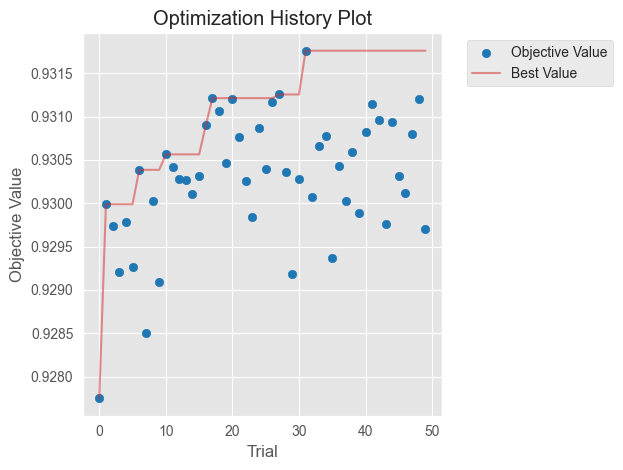

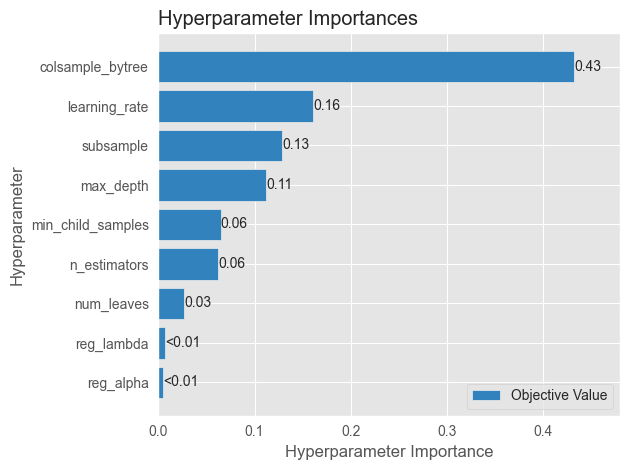

In [20]:
# Visualize optimization
plot_optimization_history(study_clf)
plt.tight_layout()
plt.show()

plot_param_importances(study_clf)
plt.tight_layout()
plt.show()

## 4. Optimize Regressor


In [21]:
def objective_regressor(trial):
    """
    Optuna objective for regressor optimization.
    Minimizes MAE on validation set.
    """
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_playing, y_train_playing)
    
    pred = np.maximum(model.predict(X_val), 0)
    mae = mean_absolute_error(y_val, pred)
    
    return mae

In [22]:
print("="*70)
print("OPTIMIZING REGRESSOR")
print("="*70)

study_reg = optuna.create_study(direction='minimize', study_name='regressor_optimization')
study_reg.optimize(objective_regressor, n_trials=50, show_progress_bar=True)

print(f"\nBest MAE: {study_reg.best_value:.4f}")
print("\nBest parameters:")
for key, value in study_reg.best_params.items():
    print(f"  {key}: {value}")


OPTIMIZING REGRESSOR


Best trial: 27. Best value: 1.54954: 100%|██████████| 50/50 [02:17<00:00,  2.74s/it]


Best MAE: 1.5495

Best parameters:
  n_estimators: 702
  learning_rate: 0.01195542670353727
  num_leaves: 122
  max_depth: 10
  min_child_samples: 72
  subsample: 0.9385102944668678
  colsample_bytree: 0.7794655740155688
  reg_alpha: 0.23726706200601874
  reg_lambda: 0.05179759979485027


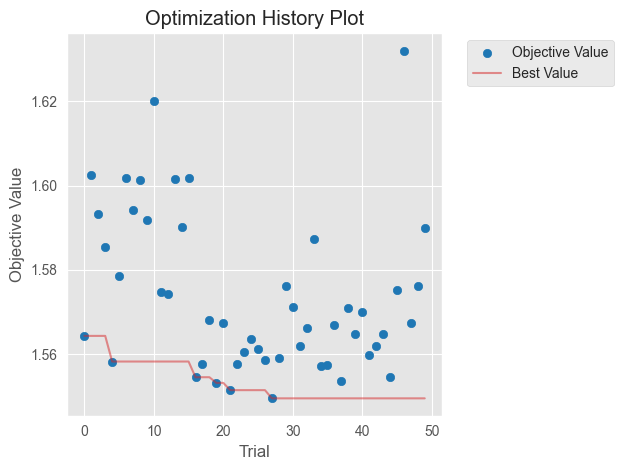

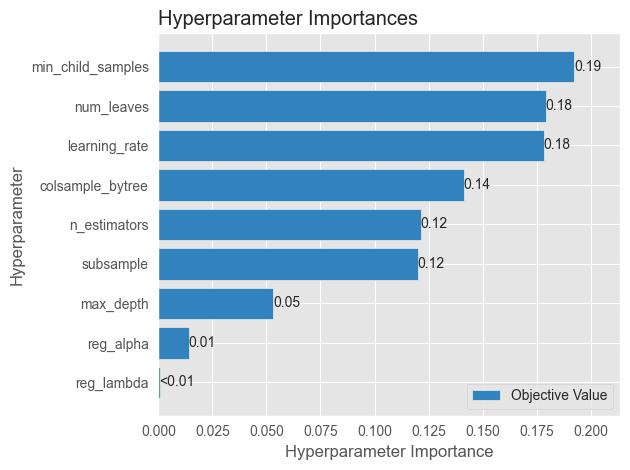

In [23]:
plot_optimization_history(study_reg)
plt.tight_layout()
plt.show()

plot_param_importances(study_reg)
plt.tight_layout()
plt.show()

## 5. Train Final Optimized Models

In [24]:
print("="*70)
print("TRAINING OPTIMIZED TWO-STAGE MODEL")
print("="*70)

# Optimal classifier
best_clf_params = study_clf.best_params
best_clf_params.update({'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'random_state': 42})
clf_optimized = lgb.LGBMClassifier(**best_clf_params)
clf_optimized.fit(X_train, y_train_binary)

prob_optimized = clf_optimized.predict_proba(X_val)[:, 1]
auc_optimized = roc_auc_score(y_val_binary, prob_optimized)

print(f"Classifier AUC: {auc_optimized:.4f} (baseline: {auc_baseline:.4f})")

# Optimal regressor
best_reg_params = study_reg.best_params
best_reg_params.update({'objective': 'regression', 'metric': 'mae', 'verbosity': -1, 'random_state': 42})
reg_optimized = lgb.LGBMRegressor(**best_reg_params)
reg_optimized.fit(X_train_playing, y_train_playing)

points_optimized = np.maximum(reg_optimized.predict(X_val), 0)

# Ensemble
pred_optimized = prob_optimized * points_optimized
mae_optimized = mean_absolute_error(y_val, pred_optimized)

print(f"Ensemble MAE:   {mae_optimized:.4f} (baseline: {mae_baseline:.4f})")
print(f"Improvement:    {(mae_baseline - mae_optimized) / mae_baseline * 100:.2f}%")


TRAINING OPTIMIZED TWO-STAGE MODEL
Classifier AUC: 0.9318 (baseline: 0.9290)
Ensemble MAE:   1.0223 (baseline: 1.0317)
Improvement:    0.92%


## 6. Apply to All Horizons

In [25]:
print("="*70)
print("OPTIMIZED MODEL: ALL HORIZONS")
print("="*70)

results_optimized = {}

for h in [1, 2, 3]:
    y_train_h = train_df[f'target_h{h}'].values
    y_val_h = val_df[f'target_h{h}'].values
    y_train_binary_h = train_df[f'will_play_h{h}'].values
    y_val_binary_h = val_df[f'will_play_h{h}'].values
    
    # Classifier
    clf = lgb.LGBMClassifier(**best_clf_params)
    clf.fit(X_train, y_train_binary_h)
    prob = clf.predict_proba(X_val)[:, 1]
    
    # Regressor
    playing_mask_h = train_df['minutes'] > 0
    X_train_playing_h = X_train[playing_mask_h]
    y_train_playing_h = y_train_h[playing_mask_h]
    
    reg = lgb.LGBMRegressor(**best_reg_params)
    reg.fit(X_train_playing_h, y_train_playing_h)
    points = np.maximum(reg.predict(X_val), 0)
    
    # Ensemble
    pred = prob * points
    mae = mean_absolute_error(y_val_h, pred)
    
    print(f"\nHorizon {h}: MAE = {mae:.4f}")
    
    results_optimized[h] = {'mae': mae, 'predictions': pred}


OPTIMIZED MODEL: ALL HORIZONS

Horizon 1: MAE = 1.0223

Horizon 2: MAE = 1.0311

Horizon 3: MAE = 1.0132


## 7. Final Comparison


FINAL COMPARISON
           Baseline  Optimized  Improvement_%
Horizon 1     1.021     1.0223        -0.1253
Horizon 2     1.055     1.0311         2.2693
Horizon 3     1.073     1.0132         5.5773


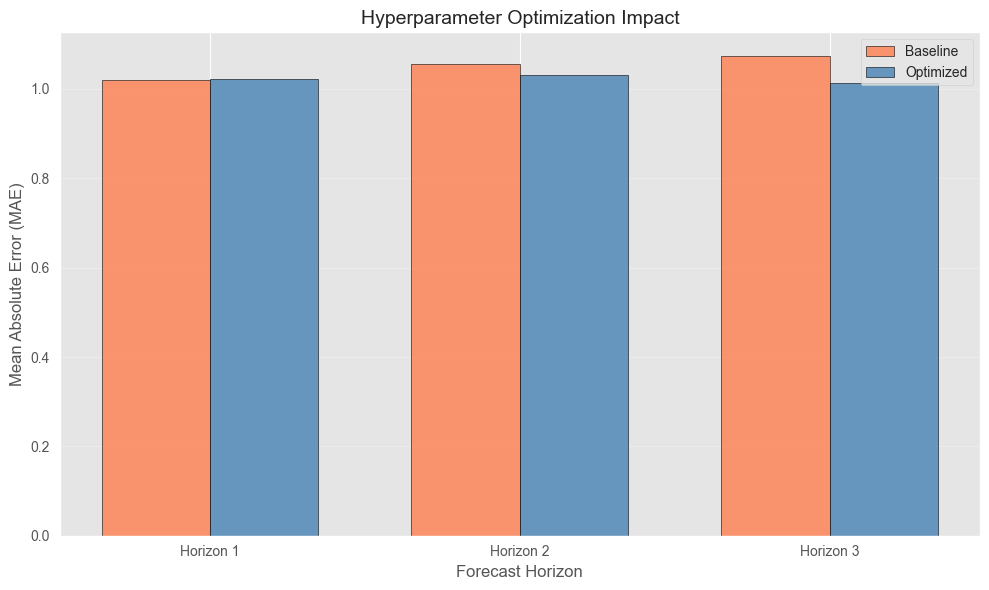

In [26]:
# Load baseline results from Notebook 03
baseline_maes = [1.021, 1.055, 1.073]  # Update with your actual values
optimized_maes = [results_optimized[h]['mae'] for h in [1, 2, 3]]

comparison_df = pd.DataFrame({
    'Baseline': baseline_maes,
    'Optimized': optimized_maes,
    'Improvement_%': [(b - o) / b * 100 for b, o in zip(baseline_maes, optimized_maes)]
}, index=['Horizon 1', 'Horizon 2', 'Horizon 3'])

print("\n" + "="*70)
print("FINAL COMPARISON")
print("="*70)
print(comparison_df.round(4))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(3)
width = 0.35

ax.bar(x - width/2, baseline_maes, width, label='Baseline', color='coral', edgecolor='black', alpha=0.8)
ax.bar(x + width/2, optimized_maes, width, label='Optimized', color='steelblue', edgecolor='black', alpha=0.8)

ax.set_xlabel('Forecast Horizon', fontsize=12)
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax.set_title('Hyperparameter Optimization Impact', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(['Horizon 1', 'Horizon 2', 'Horizon 3'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Save Optimized Models

In [27]:
import joblib

MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

# Save models for each horizon
for h in [1, 2, 3]:
    # Train final models with full pipeline
    y_train_h = train_df[f'target_h{h}'].values
    y_train_binary_h = train_df[f'will_play_h{h}'].values
    
    clf_final = lgb.LGBMClassifier(**best_clf_params)
    clf_final.fit(X_train, y_train_binary_h)
    
    playing_mask = train_df['minutes'] > 0
    reg_final = lgb.LGBMRegressor(**best_reg_params)
    reg_final.fit(X_train[playing_mask], y_train_h[playing_mask])
    
    # Save
    joblib.dump(clf_final, MODELS_DIR / f"classifier_h{h}.pkl")
    joblib.dump(reg_final, MODELS_DIR / f"regressor_h{h}.pkl")

# Save feature list
joblib.dump(feature_cols, MODELS_DIR / "feature_cols.pkl")

print(f"\nModels saved to: {MODELS_DIR}")
print("  - classifier_h1.pkl, classifier_h2.pkl, classifier_h3.pkl")
print("  - regressor_h1.pkl, regressor_h2.pkl, regressor_h3.pkl")
print("  - feature_cols.pkl")


Models saved to: c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine\models
  - classifier_h1.pkl, classifier_h2.pkl, classifier_h3.pkl
  - regressor_h1.pkl, regressor_h2.pkl, regressor_h3.pkl
  - feature_cols.pkl
